# TP6 - Salient Points Detectors and Descriptors

Detecting and describing salient points in an image has numerous real-world applications like object retrieval, the stitching of photographs into a single panoramic view, or even [SLAM](https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping). In this practical session, we will implement some primitive methods and discover more complex ones proposed by modern libraries.

Despite the simplicity of the methods we will implement, this should help you better grasp the subtleties involved in state of the art methods.

In [ ]:
# The following packages will be useful throughout the session
print("Installing and updating packages may take a minute...", end="")
!pip install -q imageio matplotlib
!pip install -q -U opencv-python scikit-image ipywidgets
print("Done.")

# For ease of use, we won't rewrite them this time
from scipy import ndimage
from skimage.feature import corner_peaks

# Usual imports
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets
import imageio
import cv2

%matplotlib inline

Installing and updating packages may take a minute...Done.


## Part 1 : Harris Corner Detector

The Harris Corner Detector is the first one covered in the course. It is very simple, as it relies on a local, single scale measure. We will implement it here. 

You are encouraged to open [the wikipedia section about it](https://en.wikipedia.org/wiki/Corner_detection#The_Harris_&_Stephens_/_Plessey_/_Shi%E2%80%93Tomasi_corner_detection_algorithms) as well as the one about the [structure tensor](https://en.wikipedia.org/wiki/Structure_tensor) to have the complete mathematical reasoning behind the formulas.

Consider taking an image patch $[x,y]$ with $x \in \mathbb{R}^W$ and $y \in \mathbb{R}^H$. Working on a grayscale image, we will have to compute the structure tensor

$$
A = \sum_u \sum_v w[u,v] 
\begin{pmatrix}
I_x[u,v]^2 & I_x[u,v] I_y[u,v] \\
I_x[u,v] I_y[u,v] & I_y[u,v]^2 
\end{pmatrix}
=
\begin{pmatrix}
\langle I_x^2 \rangle & \langle I_x I_y \rangle\\
\langle I_x I_y \rangle & \langle I_y^2 \rangle
\end{pmatrix}
$$


where $I_x$ and $I_y$ are the (periodized) horizontal and vertical partial derivatives of intensity $I$ and where the angle brackets $\langle \cdot \rangle$ simply denote weighted sum within a sliding window around every pixel (we are basically talking about a convolution with the window kernel). Therefore, $A$ ends up being a $H\times W\times 2\times 2$ tensor. 

**Note:** For a more rigorous mathematical writing of $A$, scroll down to the bottom of this notebook.

For every pixel, we are interested about the order of magnitude of the eigenvalues $\lambda_1, \lambda_2$ of $A$.

1. If $\lambda_1 \approx 0$ and $\lambda_2 \approx 0$, this pixel has no feature of interest
2. If $\lambda_1 \approx 0$ and $\lambda_2$ has some significant value (or vice-versa), we have found an edge
3. If $\lambda_1$ and $\lambda_2$ have large positive values, we have found a corner.

For performance considerations at that time (1988), the authors proposed to avoid computing the eigenvalues, considering that this decision could be made by considering that a high

$$
M_c = \lambda_1 \lambda_2 - \kappa \left( \lambda_1 + \lambda_2 \right) ^2
$$

was characteristic of corners. (with empirical values of $\kappa$ lying in $[0.04,0.15]$)

Recall that $\lambda_1\lambda_2$ is nothing but $\text{det}(A)$ and that $\lambda_1+\lambda_2$ is $\text{trace}(A)$, which allow us to compute $M_c$ very efficiently.

$$
M_c = \lambda_1 \lambda_2 - \kappa \left( \lambda_1 + \lambda_2 \right) ^2 = \text{det}(A) - \kappa \left(\text{trace}\left(A\right) \right)^2
$$

Since then, the Noble's corner measure $M'_c$ has been proposed

$$
M'_c = 2\frac{\text{det}(A)}{\text{trace}(A)+\epsilon}
$$

which we will implement as well when no $\kappa$ is provided.

Let us load a simple image, with really sharp corners and edges.

In [ ]:
# TO RUN
arrows = imageio.imread("images/blackandwhite.jpg", pilmode="I") / 255

print(arrows.shape)
plt.imshow(arrows, cmap="gray")
plt.show()

For more consistency with the previous TPs, we will keep working with the good old convolution using FFT (given for your convenience). However, keep in mind that using the `convolve` function from *scipy.ndimage* is equivalent.

`from scipy.ndimage import convolve`

In [ ]:
# TO RUN

# Remember this function from TP4_utils.py
def resize_and_fix_origin(kernel, size):
    """Pads a kernel to reach shape `size`, and shift it in order to cancel phase.
    This is based on the assumption that the kernel is centered in image space.
    """
    # Very specific routine... You don't have to understand it
    pad0, pad1 = size[0]-kernel.shape[0], size[1]-kernel.shape[1]
    # shift less if kernel is even, to start with 2 central items
    shift0, shift1 = (kernel.shape[0]-1)//2, (kernel.shape[1]-1)//2

    kernel = np.pad(kernel, ((0,pad0), (0,pad1)))
    kernel = np.roll(kernel, (-shift0, -shift1), axis=(0,1))
    return kernel

def convolve(image, kernel) :
    """
    Compute the convolution through Fourier transform
    """
    imfft = np.fft.fft2(image)
    kfft = np.fft.fft2(resize_and_fix_origin(kernel, image.shape))
    return np.fft.ifft2(kfft*imfft).real

## 1.a] $\mathbf{I_x} $ and $\mathbf{I_y} $

The [sobel filter](https://en.wikipedia.org/wiki/Sobel_operator) is a practical approximation for the derivative in an image. It allows us to compute $I_x$ and $I_y$ in the following manner :


$$
I_x = \begin{bmatrix} 
 -1 & 0 & +1  \\
-2 & 0 & +2 \\
-1 & 0 & +1 
\end{bmatrix} * I
\quad
\mbox{and}
\quad   
I_y = \begin{bmatrix} 
 -1 & -2 & -1\\
 0 & 0 & 0 \\
+1 & +2 & +1
\end{bmatrix} * I
$$

where $*$ denotes a convolution.

Let us implement it.

In [ ]:
# TO COMPLETE
def partial_derivatives(image):
    """
    Compute partial horizontal and vertical partial derivatives
    Please recall that you are allowed to use the convolve() function imported at the beginning
    """
    # Sobel horizontal and vertical kernels
    Sx = ...
    Sy = ...
    
    
    return Ix, Iy

## 1.b] $\mathbf{A}$

Now that we have $I_x$ and $I_y$ , let us compute $A$.

$$
A =
\begin{bmatrix}
\langle I_x^2 \rangle & \langle I_x I_y \rangle\\
\langle I_x I_y \rangle & \langle I_y^2 \rangle
\end{bmatrix}
$$

In our case, $w(u,v)$ will be a gaussian kernel with $\sigma$ passed as argument. It presents the advantage of being isotropic and separable. Don't hesitate to use the `gaussian_filter` function from `scipy.ndimage` imported at the beginning of this notebook.

In [ ]:
# TO COMPLETE
def computeA (Ix, Iy, sigma) :
    """
    Compute structure tensor A and return its 3 different elements as tuple
    """
    Axx = ...
    Axy = ...
    Ayy = ...

    
    return (Axx, Axy, Ayy)

# 1.c] $\mathbf{\text{det} (A)}$ and $\mathbf{\text{trace} (A)}$

We can then compute $\text{det}(A)$ and $\text{trace}(A)$.

$
\text{det}(A) = \langle I_x^2 \rangle \langle I_y^2 \rangle - \langle I_x I_y \rangle^2 \\
\text{trace}(A) = \langle I_x^2 \rangle + \langle I_y^2 \rangle \\
$

In [ ]:
# TO COMPLETE
def det_and_trace_A (Axx, Axy, Ayy) :
    """
    Compute determinant and trace of A and return them as tuple
    """
    det = ...
    trace = ...
    return (det, trace)

## 1.d] $\mathbf{\text{M}_c}$

We finally have all our components for computing our two corner measures :

$
M_c = \text{det}(A) - \kappa \left(\text{trace}\left(A\right) \right)^2 \\
M'_c = 2\frac{\text{det}(A)}{\text{trace}(A)+\epsilon}
$

In [ ]:
def compute_Mc (det, trace, k=None, eps=1e-6) :
    """
    Compute harris corner mesure Mc
    """
    
    if k is not None:
        # Harris' corner measure
        Mc = ...
    else:
        # Noble's corner measure
        Mc = ...

    
    return Mc

## Synthesis

In [ ]:
# TO RUN
def harris_corner_measure(image, k=None, sigma=1, eps=1e-6):
    """Compute the harris corner measure if k is not None, Noble's if k is None
    """
    # Compute the partial derivatives
    Ix, Iy = partial_derivatives(image)
    
    # Compute structure tensor A
    (Axx, Axy, Ayy) = computeA ( Ix, Iy, sigma)
    
    # Compute det and trace of A
    (det, trace) = det_and_trace_A (Axx, Axy, Ayy)
    
    Mc = compute_Mc (det, trace, k=k, eps=eps)

    return Mc

We now have a *corner measure* at every pixel. A corner usually impacts the score of several pixels, so we have to extract local maximas, which can prove to be complicated. For this purpose, we are going to use the `corner_peaks` function from *scikit-image* imported at the beginning of the notebook. It will basically discretize those maximas into simple coordinates that we can then emphasize.

The following cell should basically highlight the corners in red. Notice the parameters that are used to call `harris_corner_measure`. Does playing with them impact the corner measure map and/or the detected corners ?

In [ ]:
# TO RUN
def draw_corners(image, corners, thickness=5, color=(1,0,0)):
    """Draw red corners on a gray-level image using OpenCV
    """
    image = np.stack([image]*3, axis=2)  # Create RGB image to add red color
    for y, x in corners:
        cv2.circle(image, (x,y), thickness, color, -1)
    return image

@ipywidgets.interact(
    k = 0.15
)
def g(k):
    M_c = harris_corner_measure(arrows, k, sigma=2) 
    corners = corner_peaks(M_c, threshold_rel=0.1)

    plt.figure(figsize=(15,6))
    plt.subplot(121, title="Corner Measure")
    plt.imshow(M_c)
    plt.viridis() # Colours the colorbar
    plt.colorbar()

    plt.subplot(122, title="Detected Corners")
    plt.imshow(draw_corners(arrows, corners))
    plt.show()

interactive(children=(FloatSlider(value=0.15, description='k', max=0.44999999999999996, min=-0.15), Output()),…

**Question:** How does the $\kappa$ parameter affect the corner detection ? Can you explain it ?

In [ ]:
# Your discussion here

## Results on a more realistic image

Here is the image we are interested in

In [ ]:
# TO RUN
image = imageio.imread("images/cube_small.png")
plt.figure(figsize=(8,8)).gca().imshow(image);

We would like to use the Harris Corner detector to detect the corners of the red roses. 

To this aim, you will first try to extract an appropriate binary image discarding the rest of the image

In [ ]:
# TO RUN
# The first step is to get a binary image.
# We do this by specifying lower and upper bounds (thresholds) on the RGB values of the image.
# To help you, I designed a little tool allowing to find a correct set of thresholds.
R_widget = ipywidgets.IntRangeSlider(max=255, continuous_update=False)
G_widget = ipywidgets.IntRangeSlider(max=255, continuous_update=False)
B_widget = ipywidgets.IntRangeSlider(max=255, continuous_update=False)
remove_noise = ipywidgets.Checkbox(value=True, description='Remove salt and pepper noise')
window = ipywidgets.Checkbox(value=False, description='Close-up view')
@ipywidgets.interact(R_range=R_widget, G_range=G_widget, B_range=B_widget, remove_noise=remove_noise, window=window)
def _(R_range, G_range, B_range, remove_noise, window):
    R_min, R_max = R_range
    G_min, G_max = G_range
    B_min, B_max = B_range
    global thresholded
    thresholded = (  (image[:,:,0] >= R_min)
                   & (image[:,:,0] <= R_max)
                   & (image[:,:,1] >= G_min)
                   & (image[:,:,1] <= G_max)
                   & (image[:,:,2] >= B_min)
                   & (image[:,:,2] <= B_max)).astype(np.uint8)
    if window:
        thresholded = thresholded[250:600,400:650]
    thresholded = 1-thresholded
    if remove_noise:
        kernel = np.ones((7,7))
        thresholded = ndimage.binary_opening(ndimage.binary_closing(thresholded, kernel), kernel)
    fig, axes = plt.subplots(1,2,figsize=(10,10))
    axes[1].imshow(image)
    axes[0].imshow(thresholded, cmap="gray")

Once you are happy with your binary image, fix the range values here below!

In [ ]:
# TO COMPLETE
R_range_min = ...
R_range_max = ...
G_range_min = ...
G_range_max = ...
B_range_min = ...
B_range_max = ...


thresholded = (  (image[:,:,0] >= R_range_min)
               & (image[:,:,0] <= R_range_max)
               & (image[:,:,1] >= G_range_min)
               & (image[:,:,1] <= G_range_max)
               & (image[:,:,2] >= B_range_min)
               & (image[:,:,2] <= B_range_max)).astype(np.uint8)
kernel = np.ones((7,7))
thresholded = ndimage.binary_closing(ndimage.binary_opening(thresholded, kernel), kernel)
red = np.copy(image)
red[:,:,0] *= thresholded
red[:,:,1] *= thresholded
red[:,:,2] *= thresholded

thresholded = thresholded.astype(float)

plt.figure(figsize=(10,10))
plt.subplot(121, title="Beautiful rendering")
plt.imshow(red)
plt.subplot(122, title="The binary image")
plt.imshow(thresholded, cmap="gray")
plt.show()

In [ ]:
# TO RUN
default_k = 0.15
default_sigma = 1
@ipywidgets.interact(
    k=ipywidgets.FloatSlider(min=0.00,max=0.5,value=default_k,step=0.01,continuous_update=False),
    sigma=ipywidgets.FloatSlider(min=0.2,max=10,value=default_sigma,step=0.1,continuous_update=False),
)
def f(k, sigma):
    if k == 0: k = None
    M_c = harris_corner_measure(thresholded, k=k, sigma=sigma)
    corners = corner_peaks(M_c, threshold_rel=0.01)
    fig, axes = plt.subplots(1,3, figsize=(20,6))
    axes[0].set_title("Original Image")
    axes[0].imshow(image)
    
    axes[1].set_title("Corner Measure")
    c = axes[1].imshow(M_c)
    fig.colorbar(c, ax=axes[1])

    axes[2].set_title("Corners")
    axes[2].imshow(draw_corners(thresholded, corners, thickness=10))


**Question:** Does the Harris corner detector work as well as for the arrow image in this situation ? Is $\kappa$ of any use here ?

In [ ]:
# Your discussion here

You can play with the parameters in the cell below.

You are encouraged to test the detector on the *leaf* image, which is in gray level here!


You can also test the corner detection on the *circuit_large* image from TP4 (good memories :D ).

**Note:** You might be changing the `thickness` parameter of `draw_corners`.

**Using $\kappa=0$ will switch to Nobel's measure.**

In [ ]:
# TO RUN
leaf = imageio.imread("images/leaf-identification.jpg", pilmode="I") / 255
circuit = imageio.imread("images/circuit_large.png", pilmode="I") / 255
crosses = imageio.imread("images/crosses.png", pilmode="I") / 255

@ipywidgets.interact(
    image=["circuit", "crosses", "leaf", "arrows", 'thresholded'],
    k=ipywidgets.FloatSlider(min=0.00,max=0.5,value=0.15,step=0.01,continuous_update=False),
    sigma=ipywidgets.FloatSlider(min=0.2,max=3,value=2.5,step=0.1,continuous_update=False),
)
def f(image, k, sigma):
    if k == 0: k = None
    image = globals()[image]
    M_c = harris_corner_measure(image, k=k, sigma=sigma)
    corners = corner_peaks(M_c, threshold_rel=0.1)

    plt.figure(figsize=(15,6))
    plt.subplot(121, title="Corner Measure")
    plt.imshow(M_c)
    plt.colorbar()

    plt.subplot(122, title="Corners")
    plt.imshow(draw_corners(image, corners, thickness=3))
    plt.show()

**Question:** Qualitatively, given a new image, how would you choose $\sigma$? 

In [ ]:
# Your discussion here

## Part 2 : A BRIEF-like Descriptor

Salient points are usually not really useful by themselves. For doing more, we need point descriptors, so that we can pair some extracted from an image with others from another image for instance. We will here create a simple descriptor based on [BRIEF](https://infoscience.epfl.ch/record/149242/files/top_1.pdf) which as been mentioned during the lecture. Note however that ours will be a bit simplified and our implementation much less efficient.

Key properties of a good descriptor is that it should be robust enough so that a point gets about the same descriptor under different conditions (point of view, lightning, ...), but we want as much as possible to avoid having colliding descriptors for different, unrelated points.

The idea behind BRIEF is that by combining many intensity comparison tests around the point of interest, we can construct a vector that will characterize it and achieve a reasonable robustness - discriminability tradeoff.

In [ ]:
# TO RUN
def create_test_pairs(n_tests, patch_size):
    """Creates pairs of points around the origin within a certain neighborhood.
    Those pairs of points constitute comparison tests that will create a descriptor
    of the surrounding of a given point.
    
    patch_size
        the expected size of the patch to describe around origin (most of the points fit in -2std, 2std)
        when generating a gaussian. Let us simply clip the others to those limits
    """
    # Generate following a gaussian distribution
    std = patch_size / 4
    points = np.random.randn(n_tests,4) * std
    # Clip the points within the patch size and make them integers
    points = np.clip(points, -2*std, 2*std)
    points = points.astype(np.int32)
    return points

Let us create and visualize the different randomly generated pairs that will compose our descriptor: 

In [ ]:
# TO RUN
np.random.seed(0)
patch_size = 28
# Generate 100 test pairs
test_pairs = create_test_pairs(100, patch_size)

# Plot them
plt.figure(figsize=(5,5))
for x1, y1, x2, y2 in test_pairs:
    plt.plot([x1,x2], [y1,y2])
plt.gca().set_aspect(1)
plt.title("Pairs of points for building BRIEF descriptor")
plt.xlabel("$x$ offset")
plt.ylabel("$y$ offset")
plt.show()

The function `filter_border_points` prevents your testing points from being out of the image, you don't have to understand it.

In [ ]:
# TO RUN
def filter_border_points(image, salient_points, patch_size):
    """A function for filtering out salient points from an image that
    lie too close from the borders.
    """
    height, width = image.shape
    margin = patch_size / 2
    kept_points = []
    for point in salient_points:
        y, x = point
        if (y-margin < 0 or height-1 < y+margin or
            x-margin < 0 or width-1  < x+margin):
            continue
        kept_points.append(point)
    return kept_points

## 2.a] Compute_descriptors

Let us implement the routine for computing the descriptors for a list of points on a given grayscale image.

In the `compute_descriptors` function that you will implement, the objective is to output a list of tuples of boolean values that will describe all the points of interest. 

Each element in the list is a tuple linked to one point $(x,y)$ whose booleans values are computed as :

* 1 if $I[y+y_1,x+x_1] > I[y+y_2,x+x_2]$ (the intensity of the image for the first point of the pair is higher than the one of the second point).
* 0 otherwise

BRIEF authors compute the descriptors on a smoothed version of the image. To this end, you may use the `gaussian_filter` function from `scipy.ndimage` imported at the beginning of this notebook.

In [ ]:
# TO COMPLETE
def compute_descriptors(image, salient_points, test_pairs, *, sigma=1):
    """Compute the descriptors for a list of points given a pattern of test_pairs
    
    salient_points
        a list of point coordinates (y, x) to create descriptors for. 
        You can consider that no salient point will need a pixel outside the image (those points will be removed beforehand)
    test_pairs
        is a list of tuples, each providing the (x,y) coordinates of the randomly generated pairs (x1, y1, x2, y2)
    sigma
        the standard deviation of the gaussian kernel used for smoothing the image
        before computing the descriptors
    
    return value
        a list of tuples of booleans (one boolean for every test)
        every test should have the value (arbitrary choice from your teaching assistant)
            image[y+y1,x+x1] > image[y+y2,x+x2]
        the n-th descriptor in the list should correspond to the n-th element of
        salient_points
    """
    # apply gaussian filter
    ...
    descriptors = [] # Initialize empty list
    for point in salient_points:
        # TO COMPLETE
    
    return descriptors

## 2.b] Distance between the descriptors

Once we agreed on how to **find our salient points** and **compute our descriptors**, there will still be two components to consider:
- a **distance** function between descriptors of two keypoints
  - In the case of BRIEF, we use the hamming distance between descriptors (the number of tests with different outcomes)
- a **matching algorithm** for associating some keypoints from an image to other keypoints from another image or a dataset.
  - This part varies highly between the libraries. We will be using a naive *bruteforce* algorithm.

In [ ]:
# TO COMPLETE
def hamming_distance(desc_a, desc_b):
    """
    Computes the hamming distance between two tuple of booleans.
    Said another way, this is just the number of tests with different
    outcomes when characterizing the two points
    """
    # YOUR IMPLEMENTATION
    
    return ...

Now we will try to analyze the robustness of the BRIEF descriptor against translation. In this case, we will shift *leaf.png* gradually. Then we will plot the Hamming distance distribution against the pixel shift. Are you able to guess how will this distribution look like?

`Take one minute to think about it!`

Let us compute the descriptors for the detected points and compute distances with descriptors computed further and further from them. We then compare the distribution of hamming distances with respect of the distance from the original keypoints. This should be reminiscent of slide 44 in the lecture on Visual Saliency.

In [ ]:
# TO RUN
image = leaf
# Compute reference corners and descriptors
Mc = harris_corner_measure(image)
corners = corner_peaks(Mc, threshold_rel=0.1)
corners = filter_border_points(image, corners, patch_size)
descriptors_1 = compute_descriptors(image, corners, test_pairs, sigma=1)

data = []
for shift in range(28):
    # Shift the image of some amount
    image_2 = image[shift:,0:]
    # Remove points at the border
    corners_2 = filter_border_points(image_2, corners, patch_size)
    # Compute new descriptors
    descriptors_2 = compute_descriptors(image_2, corners_2, test_pairs, sigma=1)
    # Align descriptors_1 with descriptors_2, since some points have been removed
    aligned_descriptors_1 = []; j = 0
    for i in range(len(descriptors_1)):
        if (corners[i] == corners_2[j]).all():
            aligned_descriptors_1.append(descriptors_1[i])
            j += 1
    # Compute hamming distances
    data.append([])
    for d1, d2 in zip(aligned_descriptors_1, descriptors_2):
        data[-1].append(hamming_distance(d1, d2))
        
plt.figure(figsize=(15,5))
plt.boxplot(data, positions=range(28))
plt.xlabel("Shift of keypoints with respect to original")
plt.ylabel("Hamming distance distribution between original and shifted descriptors")
plt.show()

**Question:** Do you obtain a result you would have expected ? Can you interpret it ?

In [ ]:
# Your discussion here

## 2.c] A naive matching algorithm
Now that we are confident that our hamming distance must be correct since it seems to be matching correctly very similar points, we can create a very naive matching algorithm :

- $\text{matching} \leftarrow []$
- Build a $M\times N$ matrix $H$ with hamming distances between the $M$ descriptors in `descs_a` and the $N$ descriptors in `descs_b`
- Iterate up to `n` times (do not iterate more than $M$ or $N$)
  - $(i,j) \leftarrow \text{argmin}_{ij} H_{ij}$
  - Modify $H$ such that $i$ will never be chosen again, nor $j$.
  - Add $(i,j)$ to $\text{matching}$
- Return the matching

*Hint:* `np.unravel_index` may be useful to get meaningful coordinates from the result of `np.argmin`

In [ ]:
# TO COMPLETE
def naive_matching(descs_a, descs_b, n=20):
    matching = []
    
    # YOUR IMPLEMENTATION
    
    return matching

Time for testing!

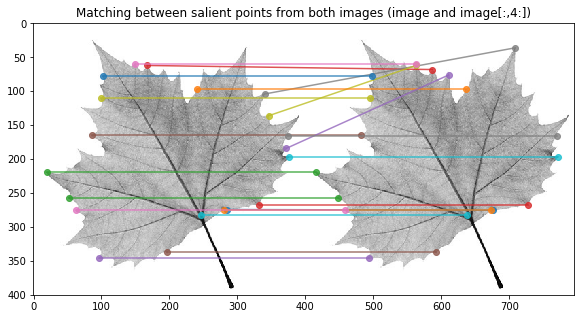

In [ ]:
# TO RUN

# Take a shifted version of our image, compute corners, descriptors
image_2 = image[:,4:]
corners_2 = filter_border_points(image_2, corners, patch_size)
descriptors_2 = compute_descriptors(image_2, corners_2, test_pairs, sigma=1)
# Match those points with the original ones
matching = naive_matching(descriptors_1, descriptors_2)

# And plot images along with matches
plt.figure(figsize=(10,5))
plt.title("Matching between salient points from both images (image and image[:,4:])")
plt.imshow(np.concatenate([image, image_2], axis=1), cmap="gray")
for i, j in matching:
    ya, xa = corners[i]
    yb, xb = corners_2[j]
    plt.plot([xa,xb+image_2.shape[1]], [ya,yb], "o-", alpha=0.8)
plt.show()

Most of the plotted matchings should be quite accurate. I personally felt really proud at this time, and you should too ;-) . It's great to see that implementing those concepts from the course are not out of reach.

Yet, this is a very simple image. We'll try it on a (more) realistic image.

## A real-life example

I have taken two simple pictures from the corridor of our lab, from two different view points. There are differences in the images, but also many similarities, and our hope is that the algorithm will be robust enough to map some of the points right.

Let us load the two images first : (in grayscale)

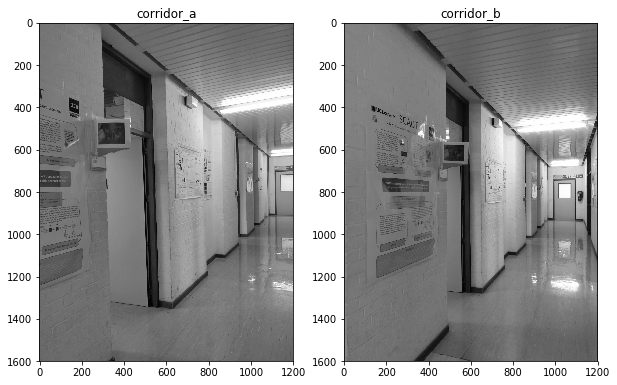

In [ ]:
# TO RUN
corridor_a = imageio.imread("images/corridor_a.jpg", pilmode="I")[1:,1:]/255
corridor_b = imageio.imread("images/corridor_b.jpg", pilmode="I")[1:,1:]/255

plt.figure(figsize=(10,8))
plt.subplot(121, title="corridor_a")
plt.imshow(corridor_a, cmap="gray")
plt.subplot(122, title="corridor_b")
plt.imshow(corridor_b, cmap="gray")
plt.show()

Let us apply our corner detection with the harris corner measure

In [ ]:
# TO RUN
Mc_a = harris_corner_measure(corridor_a, k=None, sigma=1)
Mc_b = harris_corner_measure(corridor_b, k=None, sigma=1)

# Finds the corners
corners_a = corner_peaks(Mc_a, threshold_rel=0.1)
corners_b = corner_peaks(Mc_b, threshold_rel=0.1)

plt.figure(figsize=(15,8))
plt.subplot(141, title="Mc_a")
plt.imshow(Mc_a)
plt.subplot(142, title="Mc_b")
plt.imshow(Mc_b)
plt.subplot(143, title="Corners in corridor_a")
plt.imshow(draw_corners(corridor_a, corners_a, thickness=10))
plt.subplot(144, title="Corners in corridor_b")
plt.imshow(draw_corners(corridor_b, corners_b, thickness=10))
plt.show()

Finally, let us compute some matching between the two images

In [ ]:
# TO RUN

# Filter the corners near the borders
points_a = filter_border_points(corridor_a, corners_a, patch_size)
points_b = filter_border_points(corridor_b, corners_b, patch_size)

# Compute the descriptors
descriptors_a = compute_descriptors(corridor_a, points_a, test_pairs, sigma=1)
descriptors_b = compute_descriptors(corridor_b, points_b, test_pairs, sigma=1)

# Match them with our naive algorithm
matching = naive_matching(descriptors_a, descriptors_b, n=50)

plt.figure(figsize=(15,10))
plt.title("Matching between salient points from both images")
plt.imshow(np.concatenate([corridor_a, corridor_b], axis=1), cmap="gray")
for i, j in matching:
    ya, xa = points_a[i]
    yb, xb = points_b[j]
    plt.plot([xa,xb+corridor_a.shape[1]], [ya,yb], "o-", alpha=0.8)
plt.show()

### Discussion

If you play a bit with the parameters (the $\kappa$ for corner detection, $\sigma$ for computing the descriptors), you will notice that they have quite a large impact.

This is one drawback of the simplicity of our methods. For one image, not all the parameters will work very well. We however believe implementing those was a nice way to scratch the surface of what has been taught at the lecture.

There are many interesting **questions** to ask yourself at this point :

- What are the limitations of this corner detector with respect to the most advanced ones seen at the course ?
  - Is it scale/translation/rotation-invariant ?
  - Did it find all the corners we can see in the image ? If not, is there any mathematical explanation ?
  - What do methods proposed in the course to improve over it ?
- What about the descriptor ?
  - Is it scale/translation/rotation-invariant ?
  - Could you find inspiration in the lectures to compensate for its weaknesses in that domain ?
- Are there simple priors we may use about scenes that are similar in that way to improve the matcher ?
- How could we integrate colors ?

Those questions are mainly left for you to think a bit further. However, we won't improve much our code in this session. Advanced libraries propose very simple state-of-the-art algorithms for this task, and we'll rather quickly take the time to see how it works.

## Using ORB from OpenCV

Oriented FAST and rotated BRIEF (ORB) is a fast algorithm for doing both salient point detection and description. It is very well described [in an OpenCV tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html). It basically provides an improvement of our corner detector in that it uses FAST for detecting keypoints (seen at the lecture) and that it extends BRIEF with some rotation invariance.

Compared to ours, it was also designed to work on coloured images.

Finally, the code in the tutorial is a bit out-of-date, so we'll rather show you how the different steps work.

In [ ]:
# TO RUN

# Load the images with OpenCV. For some reason, it uses BGR color ordering by convention,
# so this is not strictly the same as reading them with imageio.imread
colorridor_a = cv2.imread("images/corridor_a.jpg")
colorridor_b = cv2.imread("images/corridor_b.jpg")

# Let us plot them, with BGR channels reversed
plt.figure(figsize=(10,8))
plt.subplot(121, title="colorridor_a")
plt.imshow(colorridor_a[:,:,::-1])
plt.subplot(122, title="colorridor_b")
plt.imshow(colorridor_b[:,:,::-1])
plt.show()

As always, we'll need the following components :
- A detector for salient points (Oriented FAST)
- A descriptor method (Rotated BRIEF)
- A distance (the hamming distance)
- A matching algorithm (the BruteForce matcher from OpenCV)

In [ ]:
# Let us create the ORB 
orb = cv2.ORB_create(750)

# Compute keypoints and their descriptors
kpa, desca = orb.detectAndCompute(colorridor_a, None)
kpb, descb = orb.detectAndCompute(colorridor_b, None)

# Create the matcher, compute the matching between both lists of points
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desca, descb)

# Sort the matches with least hamming distance first
matches = sorted(matches, key=lambda match: match.distance)

# Plot them nicely (only the 50 first)
plt.figure(figsize=(15,10))
plt.title("Matching between salient points from both images")
plt.imshow(np.concatenate([colorridor_a, colorridor_b], axis=1)[:,:,::-1])
for match in matches[:50]:
    xa, ya = kpa[match.queryIdx].pt
    xb, yb = kpb[match.trainIdx].pt
    plt.plot([xa,xb+colorridor_a.shape[1]], [ya,yb], "o-", alpha=0.8)
plt.show()

**Question:** Can you explain what the BruteForce matching algorithm does ? What is the purpose of its crossCheck parameter ?

In [ ]:
# Your discussion here

Other methods have the exact same purpose, as is the case with SIFT and SURF seen at the lecture. However, those seem to be subject to specific licenses. Because of this, they are not provided anymore in the core distribution of OpenCV. One has to recompile OpenCV with the contributions module included to be able to use them, and should be aware of the conditions that apply.

## Other resources

- scikit-image corner detection [implementations](https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/corner.py) and [documentation](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=corner)

### More rigorous definition of A

$$
\begin{align*}
A[x,y,:,:] 
&=
w *
\begin{pmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2 
\end{pmatrix} \\
&=
\sum_u \sum_v w[u,v] 
\begin{pmatrix}
I_x[x-u,y-v]^2 & I_x[x-u,y-v] I_y[x-u,y-v] \\
I_x[x-u,y-v] I_y[x-u,y-v] & I_y[x-u,y-v]^2 
\end{pmatrix} \\
&= 
\begin{pmatrix}
\sum_u \sum_v w[u,v] I_x([x-u,y-v]^2 & \sum_u \sum_v w[u,v] I_x[x-u,y-v] I_y[x-u,y-v] \\
\sum_u \sum_v w[u,v] I_x[x-u,y-v] I_y[x-u,y-v] & \sum_u \sum_v w[u,v] I_y[x-u,y-v]^2 
\end{pmatrix} \\
&=
\begin{pmatrix}
\langle I_x^2 \rangle & \langle I_x I_y \rangle\\
\langle I_x I_y \rangle & \langle I_y^2 \rangle
\end{pmatrix}
\end{align*}
$$


where $*$ denotes a convolution.